In [785]:

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from datetime import datetime, timedelta

# import custom modules
sys.path.append('../utils')
import data_paths
import traffic_counts
import excel_calendar

from lmu_meteo_api import interface
from datetime import datetime
from math import sqrt


In [ ]:
DTV_visum -> constant for the whole period

alpha(daily) -> daily scaling factor to scale the VISUM model
gamma(daily) -> daily vehicle share for each vehicle class and road type

beta(hourly) -> mothly diurnal cycle for each vehicle class 

### Import data

In [685]:
_counts = traffic_counts.TrafficCounts()
counts = _counts.counting_df

In [786]:
def iqr_mean(input, iqr_range = (5,95)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return np.mean(input[(input >= lower_bound) & (input <= upper_bound)])

# normalize traffic counts to 2019 average weekday outside vaction count
# this allows to directly use the normed counts to scale the visum model to unobserved days 
# only consider complete timeseries (data coverage > 80%) 
mean_2019 = counts[(counts['date'].between('2019-01-01','2019-12-31')) &
                   (counts['day_type'] == 0) &
                   (counts['complete'])]\
                       .groupby(['road_link_id','vehicle_class'])['daily_value'].apply(iqr_mean).reset_index()
    
counts_norm = pd.merge(counts, mean_2019, on=['road_link_id','vehicle_class'], suffixes=('','_mean'))
counts_norm['daily_value'] = counts_norm['daily_value'] / counts_norm['daily_value_mean']
counts_norm = counts_norm.drop('daily_value_mean', axis = 1)

# normalize daily cycles
counts_norm.iloc[:,-24:] = counts_norm.iloc[:,-24:].div(counts_norm.iloc[:,-24:].sum(axis =1), axis = 0)

# remove this useless road type category (only 1 counting station)
counts_norm.loc[counts_norm['road_type']=='Access-residential', 'road_type'] = 'Local/Collector'

### Vehicle shares

Daily share of different vehicle types (PC, HG, LCV, MOT, BUS) on different road types. <br>
Sum of all shares of a specific day should be 1. 

In [801]:
# prepare dataframes for vehicle share calculation
daily_median = counts[(counts['complete']) &
                      (counts['vehicle_class'].isin(['HGV', 'LCV', 'PC', 'MOT', 'BUS']))]\
    .groupby(['vehicle_class', 'road_type', 'date'])['daily_value'].median()

# calculate total number of vehicles -> SUM vehicle cannot be used since it is not 
# consistent with the sum of all indivicual vehicle classes in some cases
sum_cnt = daily_median['PC'] + daily_median['LCV'] + daily_median['HGV'] + daily_median['MOT'] + daily_median['BUS']


def get_vehicle_shares(road_type):
    shares = daily_median / sum_cnt
    return shares.loc[road_type,:,:]

# test the function
df = get_vehicle_shares('TrunkRoad/Primary-National')

### Annual cylces
Here we only consider the SUM values of the traffic counts. <br>
The median of all daily counts of all counting stations on a certain road type appears to be the most robust statistical value for this purpose.

<Axes: xlabel='date'>

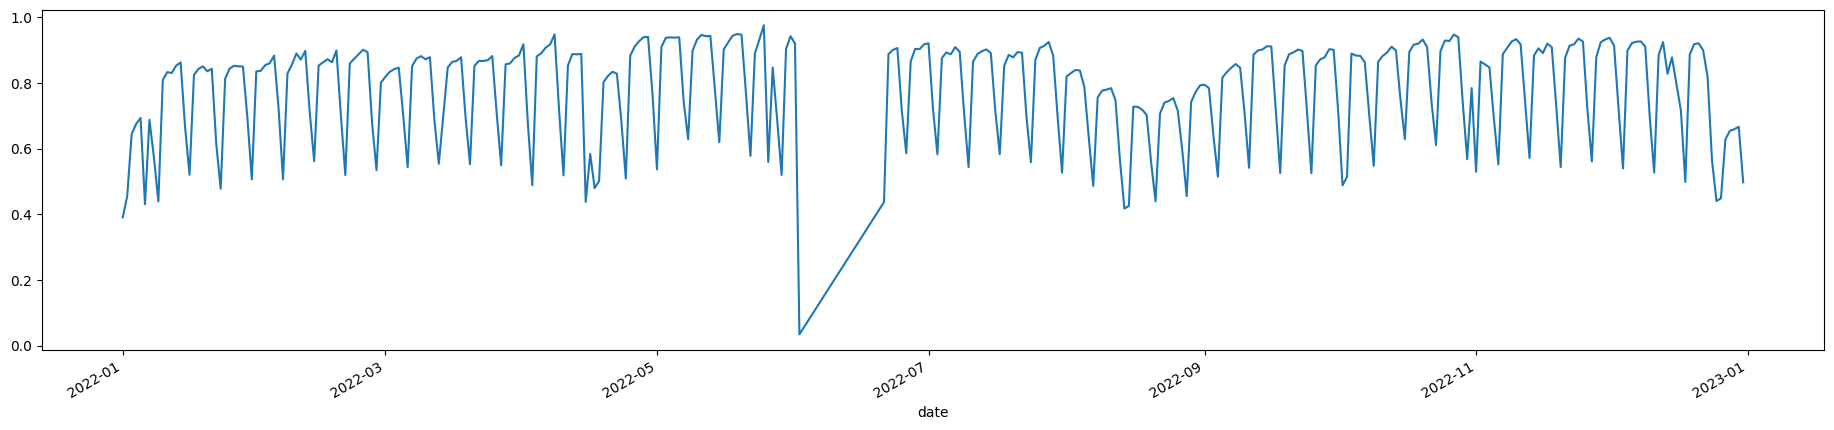

In [803]:
counts_norm_sum = counts_norm[counts_norm['vehicle_class']=='SUM']
cycles = counts_norm_sum.groupby(['road_type','date'])['daily_value'].median()

def get_annual_cycle(road_type):
    return cycles[road_type].sort_index()

plt.figure(figsize=(23,5))
get_annual_cycle('Local/Collector').loc['2022'].plot()

### Daily cycles
 The daily cycles do not differ much between different road types. Huge differences are between different day types and vehicle types. A monthly, day-type and vehicly type specific grouping was selected in this case.

In [823]:
# since the diurnal cycles are not significantly different between differnt road types, they were aggregated to one single road type and month
irrelevant_rows = ['road_type','road_link_id','daily_value', 'complete', 'valid']
d_cycles = counts_norm.drop(irrelevant_rows, axis=1).set_index('date').groupby(['day_type', 'vehicle_class']).resample('1m').mean()
d_cycles = d_cycles.reset_index()
d_cycles.insert(2, 'month', d_cycles['date'].dt.month)
d_cycles.insert(2, 'year', d_cycles['date'].dt.year)
d_cycles = d_cycles.drop('date', axis = 1)

d_cycles = d_cycles.set_index(['year','month', 'day_type'])

In [826]:
cal = excel_calendar.Calendar()

def get_daily_cycle(datestring): 
    dt = cal.get_day_type_combined(datestring)
    year = datetime.strptime(datestring, '%Y-%m-%d').year
    month = datetime.strptime(datestring, '%Y-%m-%d').month
    
    cycle = d_cycles.loc[year, month, dt].set_index('vehicle_class')
    
    return cycle
    
get_daily_cycle('2019-01-01')

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_1685/2688813034.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  cycle = d_cycles.loc[year, month, dt].set_index('vehicle_class')


,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
vehicle_class,,,,,,,,,,,,,,,,,,,,,
BUS,0.020310,0.025480,0.013579,0.010733,0.024046,0.031635,0.034127,0.046061,0.050542,0.043398,...,0.046153,0.051313,0.045516,0.056443,0.064617,0.058879,0.043465,0.037158,0.041783,0.035966
HGV,0.026480,0.029672,0.017292,0.019788,0.026032,0.035022,0.034094,0.035821,0.039425,0.038330,...,0.049520,0.052083,0.060092,0.058441,0.056142,0.045092,0.039138,0.040840,0.052189,0.057282
LCV,0.018566,0.014358,0.012667,0.010408,0.010135,0.012143,0.017950,0.024000,0.030858,0.041227,...,0.077430,0.071515,0.070820,0.075091,0.068060,0.057646,0.044781,0.033927,0.027769,0.021148
MOT,0.022082,0.024680,0.021175,0.015810,0.017112,0.027612,0.034270,0.027140,0.026338,0.041741,...,0.064855,0.063209,0.052299,0.075947,0.063976,0.055331,0.052322,0.037261,0.034745,0.025379
PC,0.019889,0.015050,0.010814,0.008796,0.006654,0.008841,0.011624,0.014857,0.022144,0.036651,...,0.083643,0.077291,0.078773,0.081925,0.072550,0.061267,0.046559,0.035507,0.025111,0.016421
SUM,0.020129,0.015676,0.011393,0.008904,0.007336,0.009271,0.011902,0.015529,0.022588,0.036148,...,0.081132,0.077166,0.077587,0.081134,0.073575,0.061430,0.048145,0.037295,0.026837,0.017019
